In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

import scanpy as sc

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

os.makedirs("results/figures", exist_ok=True)
os.makedirs("results/metrics", exist_ok=True)
os.makedirs("models", exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


In [3]:
adata = sc.datasets.pbmc3k_processed()

# Use the provided "louvain" as labels (common tutorial setup)
# If your dataset has different label column, adjust here.
label_col = "louvain"
adata.obs[label_col] = adata.obs[label_col].astype(str)

print(adata)
print(adata.obs[label_col].value_counts())

# X can be sparse; convert to dense float32 for PyTorch
X = adata.X
if not isinstance(X, np.ndarray):
    X = X.toarray()
X = X.astype(np.float32)

# Encode labels -> integers
classes = sorted(adata.obs[label_col].unique())
class_to_int = {c:i for i,c in enumerate(classes)}
y = adata.obs[label_col].map(class_to_int).values.astype(np.int64)

print("X shape:", X.shape, "y shape:", y.shape, "n_classes:", len(classes))

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
louvain
CD4 T cells          1144
CD14+ Monocytes       480
B cells               342
CD8 T cells           316
NK cells              154
FCGR3A+ Monocytes     150
Dendritic cells        37
Megakaryocytes         15
Name: count, dtype: int64
X shape: (2638, 1838) y shape: (2638,) n_classes: 8


In [5]:
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, random_state=0, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=0, stratify=y_tmp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (1846, 1838) Val: (396, 1838) Test: (396, 1838)


In [7]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, n_in: int, latent_dim: int = 64, hidden1: int = 512, hidden2: int = 128, dropout_in: float = 0.2):
        super().__init__()
        self.dropout_in = nn.Dropout(dropout_in)

        self.encoder = nn.Sequential(
            nn.Linear(n_in, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, n_in),
        )

    def forward(self, x):
        x_noisy = self.dropout_in(x)   # denoising trick: corrupt input
        z = self.encoder(x_noisy)
        x_hat = self.decoder(z)
        return x_hat, z

n_in = X_train.shape[1]
ae = DenoisingAutoencoder(n_in=n_in, latent_dim=64, dropout_in=0.2).to(device)
ae

DenoisingAutoencoder(
  (dropout_in): Dropout(p=0.2, inplace=False)
  (encoder): Sequential(
    (0): Linear(in_features=1838, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1838, bias=True)
  )
)

In [9]:
batch_size = 128
lr = 1e-3
epochs = 50

train_ds = TensorDataset(torch.from_numpy(X_train))
val_ds   = TensorDataset(torch.from_numpy(X_val))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=lr)

train_losses, val_losses = [], []
best_val = float("inf")
patience, bad = 8, 0

for epoch in range(1, epochs + 1):
    ae.train()
    running = 0.0
    for (xb,) in train_loader:
        xb = xb.to(device)
        optimizer.zero_grad()
        xhat, _ = ae(xb)
        loss = criterion(xhat, xb)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)

    train_loss = running / len(train_ds)

    ae.eval()
    running = 0.0
    with torch.no_grad():
        for (xb,) in val_loader:
            xb = xb.to(device)
            xhat, _ = ae(xb)
            loss = criterion(xhat, xb)
            running += loss.item() * xb.size(0)
    val_loss = running / len(val_ds)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d} | train MSE {train_loss:.4f} | val MSE {val_loss:.4f}")

    # early stopping
    if val_loss < best_val - 1e-5:
        best_val = val_loss
        bad = 0
        torch.save(ae.state_dict(), "models/autoencoder_best.pt")
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

Epoch 01 | train MSE 0.8645 | val MSE 0.8684
Epoch 02 | train MSE 0.8432 | val MSE 0.8493
Epoch 03 | train MSE 0.8308 | val MSE 0.8398
Epoch 04 | train MSE 0.8235 | val MSE 0.8377
Epoch 05 | train MSE 0.8175 | val MSE 0.8348
Epoch 06 | train MSE 0.8102 | val MSE 0.8331
Epoch 07 | train MSE 0.8025 | val MSE 0.8331
Epoch 08 | train MSE 0.7943 | val MSE 0.8314
Epoch 09 | train MSE 0.7855 | val MSE 0.8314
Epoch 10 | train MSE 0.7759 | val MSE 0.8316
Epoch 11 | train MSE 0.7667 | val MSE 0.8319
Epoch 12 | train MSE 0.7571 | val MSE 0.8330
Epoch 13 | train MSE 0.7472 | val MSE 0.8336
Epoch 14 | train MSE 0.7373 | val MSE 0.8355
Epoch 15 | train MSE 0.7280 | val MSE 0.8368
Epoch 16 | train MSE 0.7194 | val MSE 0.8379
Early stopping.


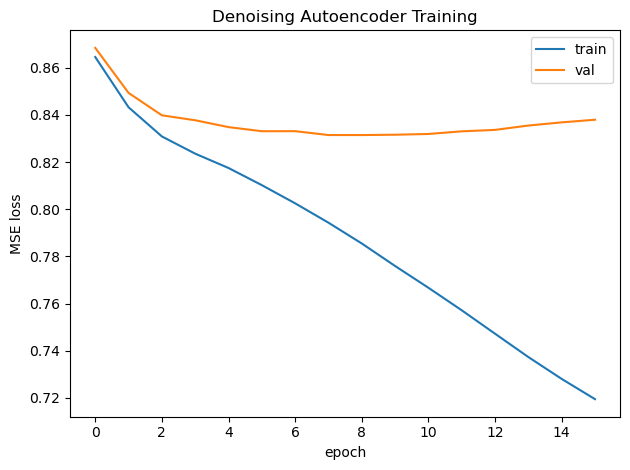

Saved: results/figures/ae_loss_curve.png


In [11]:
plt.figure()
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Denoising Autoencoder Training")
plt.legend()
plt.tight_layout()
plt.savefig("results/figures/ae_loss_curve.png", dpi=200)
plt.show()

print("Saved: results/figures/ae_loss_curve.png")

In [13]:
ae.load_state_dict(torch.load("models/autoencoder_best.pt", map_location=device))
ae.eval()

def get_latent(X_np: np.ndarray, batch_size: int = 256) -> np.ndarray:
    zs = []
    loader = DataLoader(TensorDataset(torch.from_numpy(X_np)), batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for (xb,) in loader:
            xb = xb.to(device)
            _, z = ae(xb)
            zs.append(z.cpu().numpy())
    return np.vstack(zs)

Z_train = get_latent(X_train)
Z_val   = get_latent(X_val)
Z_test  = get_latent(X_test)

Z_all = get_latent(X)  # for UMAP visualization
print("Latent shapes:", Z_train.shape, Z_test.shape, Z_all.shape)

Latent shapes: (1846, 64) (396, 64) (2638, 64)


/Users/Chris/miniconda3/envs/tensorflow/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


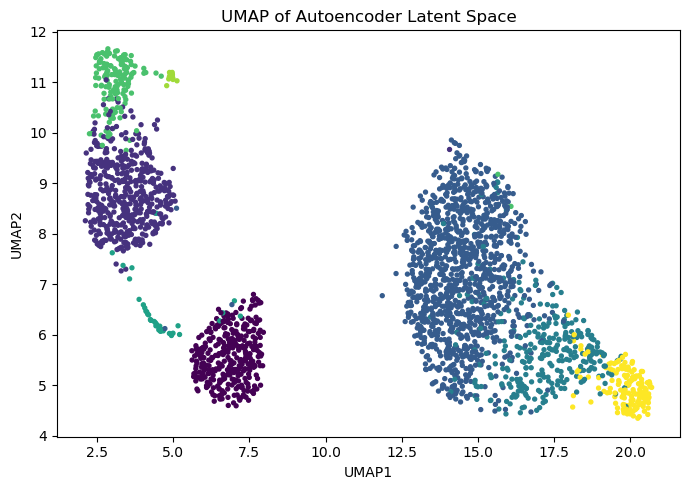

Saved: results/figures/ae_latent_umap.png


In [15]:
import umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=0)
U = reducer.fit_transform(Z_all)

plt.figure(figsize=(7,5))
plt.scatter(U[:,0], U[:,1], c=y, s=8)
plt.title("UMAP of Autoencoder Latent Space")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.tight_layout()
plt.savefig("results/figures/ae_latent_umap.png", dpi=200)
plt.show()

print("Saved: results/figures/ae_latent_umap.png")

In [17]:
# Latent classifier (fast baseline)
clf_latent = LogisticRegression(max_iter=2000, n_jobs=1)
clf_latent.fit(Z_train, y_train)
pred_latent = clf_latent.predict(Z_test)

# Raw classifier baseline
clf_raw = LogisticRegression(max_iter=2000, n_jobs=1)
clf_raw.fit(X_train, y_train)
pred_raw = clf_raw.predict(X_test)

def report(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    print(f"\n{name} accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=classes))
    out = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    pd.DataFrame(out).T.to_csv(f"results/metrics/{name}_classification_report.csv")

report("latent_logreg", y_test, pred_latent)
report("raw_logreg", y_test, pred_raw)

print("Saved reports in results/metrics/")


latent_logreg accuracy: 0.9419
                   precision    recall  f1-score   support

          B cells       1.00      1.00      1.00        52
  CD14+ Monocytes       0.95      0.99      0.97        72
      CD4 T cells       0.96      0.96      0.96       171
      CD8 T cells       0.78      0.85      0.82        47
  Dendritic cells       1.00      0.67      0.80         6
FCGR3A+ Monocytes       0.95      0.91      0.93        23
   Megakaryocytes       1.00      1.00      1.00         2
         NK cells       0.95      0.78      0.86        23

         accuracy                           0.94       396
        macro avg       0.95      0.90      0.92       396
     weighted avg       0.94      0.94      0.94       396


raw_logreg accuracy: 0.9571
                   precision    recall  f1-score   support

          B cells       1.00      0.98      0.99        52
  CD14+ Monocytes       0.92      1.00      0.96        72
      CD4 T cells       0.98      0.98      0.98  